In [40]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from keras.optimizers import SGD

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
# /content/drive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/drive/MyDrive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/MyDrive/Kaggle


**Download the dataset**

In [ ]:
!kaggle datasets download -d harishvutukuri/dogs-vs-wolves --force

 98% 217M/222M [00:07<00:00, 71.7MB/s]
100% 222M/222M [00:07<00:00, 32.1MB/s]


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

In [23]:
import pathlib
data_dir = tf.keras.utils.get_file('/content/drive/MyDrive/Kaggle/data', origin="/content/drive/MyDrive/Kaggle/data")
data_dir = pathlib.Path(data_dir)

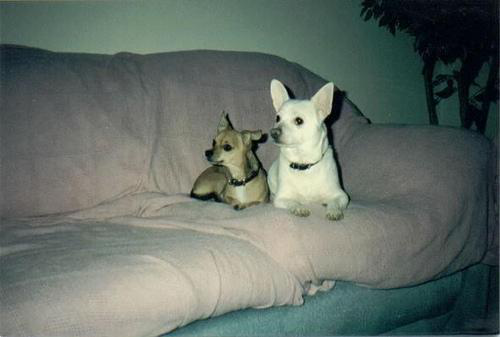

In [24]:
dogs = list(data_dir.glob('dogs/*'))
PIL.Image.open(str(dogs[10]))

In [25]:
batch_size = 64
img_height = 300
img_width = 300
epochs = 40
num_classes = 2

In [26]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=128,
    image_size=(img_height, img_width)
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=128,
    image_size=(img_height,img_width)
)
class_names = train_ds.class_names
print(class_names)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.
['dogs', 'wolves']


In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
augmentation_layer = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal",
                                    input_shape=(img_height, img_width, 3)),
     layers.experimental.preprocessing.RandomRotation(0.1),
     layers.experimental.preprocessing.RandomRotation(0.2),
     layers.experimental.preprocessing.RandomZoom(0.2)
    ]
)

In [29]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [45]:
opt = SGD(learning_rate=0.001)


model = keras.Sequential(
    [
     augmentation_layer,
     normalization_layer,
     layers.Conv2D(64, 3, padding='same', activation='elu'),
     layers.MaxPooling2D(),
     
     layers.Conv2D(32, 3, padding='same', activation='elu'),
     layers.MaxPooling2D(),
     
     layers.Conv2D(16, 3, padding='same', activation='elu'),
     layers.MaxPooling2D(),

     layers.Conv2D(16, 3, padding='same', activation='elu'),
     layers.MaxPooling2D(),
     
     layers.Dense(128, activation='relu'),

     layers.Conv2D(16, 3, padding='same', activation='elu'),
     layers.MaxPooling2D(),

     layers.Dropout(0.1),
     layers.BatchNormalization(),
     layers.Flatten(),

     layers.Dense(128, activation='relu'),
     layers.Dense(num_classes, activation='sigmoid')
    ]
)

In [54]:
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 300, 300, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 150, 150, 32)      18464     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 75, 75, 16)      

In [55]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, 
    batch_size=batch_size
)

Epoch 1/40
50/50 [==============================] - 38s 122ms/step - loss: 0.5088 - accuracy: 0.7600 - val_loss: 0.5213 - val_accuracy: 0.7525
Epoch 2/40
50/50 [==============================] - 6s 118ms/step - loss: 0.4998 - accuracy: 0.7563 - val_loss: 0.5002 - val_accuracy: 0.7625
Epoch 3/40
50/50 [==============================] - 6s 118ms/step - loss: 0.4961 - accuracy: 0.7613 - val_loss: 0.5175 - val_accuracy: 0.7400
Epoch 4/40
50/50 [==============================] - 6s 119ms/step - loss: 0.5019 - accuracy: 0.7663 - val_loss: 0.6167 - val_accuracy: 0.6600
Epoch 5/40
50/50 [==============================] - 6s 118ms/step - loss: 0.4892 - accuracy: 0.7588 - val_loss: 0.5481 - val_accuracy: 0.7250
Epoch 6/40
50/50 [==============================] - 6s 119ms/step - loss: 0.5013 - accuracy: 0.7638 - val_loss: 0.5630 - val_accuracy: 0.7200
Epoch 7/40
50/50 [==============================] - 6s 119ms/step - loss: 0.4963 - accuracy: 0.7625 - val_loss: 0.4890 - val_accuracy: 0.7525
Epoch

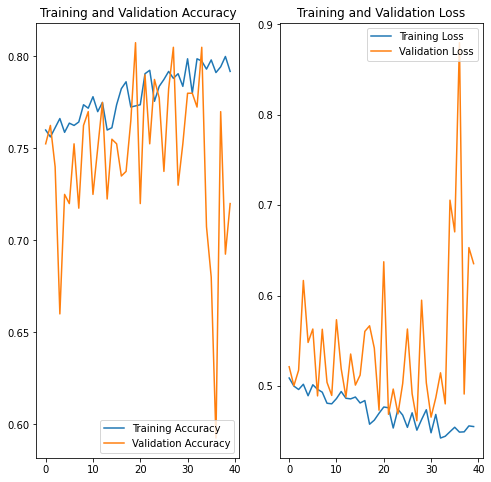

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Inference**

In [ ]:
x = True
print("type 'exit' to quit")
while x:
    test_url = input("\nenter the url for your image\n>>> ")
    if test_url == "exit":
        x = False
    else:
        l = test_url.split('/')
        filename = l[-1]
        test_path = tf.keras.utils.get_file(filename, origin=test_url)
        img = keras.preprocessing.image.load_img(
        test_path, target_size=(img_height, img_width)
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        print(
        "Predicted: {} ... Accuracy: {:.2f}% ..."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
        )
